In [1]:
import os
import numpy as np
import geopandas as gpd
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from shapely.geometry import Point
from pyproj import Transformer
import contextily as ctx
from asp_plot.camera_optimization import read_positions_rotations, read_angles, poly_fit

## Methods for extraction and plotting

In [2]:
def reproject_ecef(positions, to_epsg=4326):
    transformer = Transformer.from_crs("EPSG:4978", f"EPSG:{to_epsg}")
    x, y, z = transformer.transform(positions[:, 0], positions[:, 1], positions[:, 2])
    return np.column_stack((x, y, z))

def get_orbit_plot_gdf(original_camera, optimized_camera, map_crs):
    """
    Get a GeoDataFrame for plotting the difference between the original and optimized camera positions and rotations.
    Methods largely taken from orbit_plot.py in StereoPipeline, but modified to return the data we want for plotting.
    """
    # orbit_plot.py method to get angles in NED
    # https://github.com/NeoGeographyToolkit/StereoPipeline/blob/master/src/asp/Tools/orbit_plot.py#L412
    # This method already calls read_positions_rotations below, but it 
    # doesn't return the positions and rotations we want for plotting
    original_rotation_angles, optimized_rotation_angles = read_angles([original_camera], [optimized_camera], [])

    # orbit_plot.py method to get positions and rotations
    # https://github.com/NeoGeographyToolkit/StereoPipeline/blob/master/src/asp/Tools/orbit_plot.py#L381
    # Could be retrieved from the above method, by adding to return statement there
    original_positions_ecef, original_rotations = read_positions_rotations([original_camera])
    optimized_positions_ecef, optimized_rotations = read_positions_rotations([optimized_camera])
    original_positions_ecef = np.array(original_positions_ecef)
    optimized_positions_ecef = np.array(optimized_positions_ecef)

    # Interpolate original values if lengths don't match
    if len(original_positions_ecef) != len(optimized_positions_ecef):
        original_positions_ecef = np.array([np.interp(np.linspace(0, 1, len(optimized_positions_ecef)), 
                                            np.linspace(0, 1, len(original_positions_ecef)), 
                                            original_positions_ecef[:, i]) for i in range(3)]).T

    # Taken directly from orbit_plot.py
    # https://github.com/NeoGeographyToolkit/StereoPipeline/blob/master/src/asp/Tools/orbit_plot.py#L600-L607
    # "The order is roll, pitch, yaw, as returned by R.from_matrix().as_euler('XYZ',degrees=True)"
    original_roll   = np.array([r[0] for r in original_rotation_angles])
    original_pitch  = np.array([r[1] for r in original_rotation_angles])
    original_yaw    = np.array([r[2] for r in original_rotation_angles])
    optimized_roll  = np.array([r[0] for r in optimized_rotation_angles])
    optimized_pitch = np.array([r[1] for r in optimized_rotation_angles])
    optimized_yaw   = np.array([r[2] for r in optimized_rotation_angles])

    # Interpolate original angles if lengths don't match
    if len(original_roll) != len(optimized_roll):
        original_roll = np.interp(np.linspace(0, 1, len(optimized_roll)), 
                                  np.linspace(0, 1, len(original_roll)), 
                                  original_roll)
        original_pitch = np.interp(np.linspace(0, 1, len(optimized_pitch)), 
                                   np.linspace(0, 1, len(original_pitch)), 
                                   original_pitch)
        original_yaw = np.interp(np.linspace(0, 1, len(optimized_yaw)), 
                                 np.linspace(0, 1, len(original_yaw)), 
                                 original_yaw)

    # We are interested in the difference between the original and optimized angles
    roll_diff = original_roll - optimized_roll
    pitch_diff = original_pitch - optimized_pitch
    yaw_diff = original_yaw - optimized_yaw

    # Also get angular diff magnitude
    angular_diff_magnitudes = np.sqrt(roll_diff**2 + pitch_diff**2 + yaw_diff**2)

    # Reproject positions from ECEF to map_crs
    original_positions = reproject_ecef(original_positions_ecef, to_epsg=map_crs)
    optimized_positions = reproject_ecef(optimized_positions_ecef, to_epsg=map_crs)

    # Calculate the difference between the original and optimized positions
    position_diffs = original_positions - optimized_positions
    x_position_diff = position_diffs[:, 0]
    y_position_diff = position_diffs[:, 1]
    z_position_diff = position_diffs[:, 2]

    # Get the magntiude of position difference
    # Below is equivalent to: np.sqrt(x_position_diff**2 + y_position_diff**2 + z_position_diff**2)
    position_diff_magnitudes = np.linalg.norm(position_diffs, axis=1)

    # Build a GeoDataFrame for plotting
    data = {
        "original_positions": [Point(x, y, z) for x, y, z in original_positions],
        "optimized_positions": [Point(x, y, z) for x, y, z in optimized_positions],
        # "original_rotations": [r for r in original_rotations],
        # "optimized_rotations": [r for r in optimized_rotations],
        "position_diff_magnitude": position_diff_magnitudes,
        "x_position_diff": x_position_diff,
        "y_position_diff": y_position_diff,
        "z_position_diff": z_position_diff,
        "angular_diff_magnitude": angular_diff_magnitudes,
        "original_roll": original_roll,
        "original_pitch": original_pitch,
        "original_yaw": original_yaw,
        "optimized_roll": optimized_roll,
        "optimized_pitch": optimized_pitch,
        "optimized_yaw": optimized_yaw,
        "roll_diff": roll_diff,
        "pitch_diff": pitch_diff,
        "yaw_diff": yaw_diff,
    }
    df = pd.DataFrame(data)
    gdf = gpd.GeoDataFrame(df, geometry="original_positions")
    gdf.set_crs(epsg=map_crs, inplace=True);
    # If we wanted to keep things in ECEF
    # gdf.set_crs(epsg="4978", inplace=True);
    return gdf

def trim_gdf(
    gdf,
    trim_percentage=10,
    near_zero_tolerance=1e-8
):
    non_zero_indices = np.where(np.abs(gdf.position_diff_magnitude) > near_zero_tolerance)[0]
    # Find the first non-zero value from the start
    start_index = non_zero_indices[0]
    # Find the first non-zero value from the end
    end_index = non_zero_indices[-1]
    # Apply additional trimming
    total_length = end_index - start_index + 1
    additional_trim = int(total_length * (trim_percentage / 100) / 2)
    start_index += additional_trim
    end_index -= additional_trim
    
    return gdf.iloc[start_index:end_index+1].reset_index(drop=True)

def summary_plot_two_camera_optimization(
    cam1_list,
    cam2_list,
    map_crs,
    title,
    trim=False,
    trim_percentage=10,
    near_zero_tolerance=1e-8,
    shared_scales=True,
    log_scale_positions=True,
    log_scale_angles=True,
    upper_magnitude_percentile=95,
    figsize=(16, 12),
    **ctx_kwargs
):

    original_camera1, optimized_camera1 = cam1_list
    original_camera2, optimized_camera2 = cam2_list
    cam1_name = os.path.basename(original_camera1).split(".")[0]
    cam2_name = os.path.basename(original_camera2).split(".")[0]
    gdf_cam1 = get_orbit_plot_gdf(original_camera1, optimized_camera1, map_crs)
    gdf_cam2 = get_orbit_plot_gdf(original_camera2, optimized_camera2, map_crs)

    # Trim the beginning and end of the geodataframes
    if trim:
      gdf_cam1 = trim_gdf(gdf_cam1, trim_percentage=trim_percentage, near_zero_tolerance=near_zero_tolerance)
      gdf_cam2 = trim_gdf(gdf_cam2, trim_percentage=trim_percentage, near_zero_tolerance=near_zero_tolerance)

    fig, axes = plt.subplots(4, 4, figsize=figsize)

    # Calculate colorbar ranges
    position_values = gdf_cam1.position_diff_magnitude
    angular_values = gdf_cam1.angular_diff_magnitude
    cam1_position_vmin, cam1_position_vmax = np.percentile(position_values, [0, upper_magnitude_percentile])
    cam1_angular_vmin, cam1_angular_vmax = np.percentile(angular_values, [0, upper_magnitude_percentile])
    position_values = gdf_cam2.position_diff_magnitude
    angular_values = gdf_cam2.angular_diff_magnitude
    cam2_position_vmin, cam2_position_vmax = np.percentile(position_values, [0, upper_magnitude_percentile])
    cam2_angular_vmin, cam2_angular_vmax = np.percentile(angular_values, [0, upper_magnitude_percentile])

    # Camera 1 mapview plot
    ax = axes[0, 0]
    im1 = gdf_cam1.plot(ax=ax, column="position_diff_magnitude", cmap="viridis", markersize=10, vmin=cam1_position_vmin, vmax=cam1_position_vmax)
    ax.set_title(f"Camera 1: Position Change\n{cam1_name}", fontsize=10)
    ax.tick_params(labelsize=9)
    ax.set_xlabel("Easting (m)", fontsize=9)
    ax.set_ylabel("Northing (m)", fontsize=9)
    ctx.add_basemap(ax=ax, **ctx_kwargs)
    sm1 = ScalarMappable(norm=Normalize(vmin=cam1_position_vmin, vmax=cam1_position_vmax), cmap="viridis")
    cbar1 = plt.colorbar(sm1, ax=ax, orientation="vertical", aspect=30, pad=0.05)
    cbar1.set_label(f"Diff Magnitude (m)\nto {upper_magnitude_percentile}th perc.", fontsize=9)
    cbar1.ax.tick_params(labelsize=9)

    # Camera 1 angular mapview plot
    ax = axes[1, 0]
    im2 = gdf_cam1.plot(ax=ax, column="angular_diff_magnitude", cmap="inferno", markersize=10, vmin=cam1_angular_vmin, vmax=cam1_angular_vmax)
    ax.set_title(f"Camera 1: Angle Change\n{cam1_name}", fontsize=10)
    ax.tick_params(labelsize=9)
    ax.set_xlabel("Easting (m)", fontsize=9)
    ax.set_ylabel("Northing (m)", fontsize=9)
    ctx.add_basemap(ax=ax, **ctx_kwargs)
    sm2 = ScalarMappable(norm=Normalize(vmin=cam1_angular_vmin, vmax=cam1_angular_vmax), cmap="inferno")
    cbar2 = plt.colorbar(sm2, ax=ax, orientation="vertical", aspect=30, pad=0.05)
    cbar2.set_label(f"Diff Magnitude (deg)\nto {upper_magnitude_percentile}th perc.", fontsize=9)
    cbar2.ax.tick_params(labelsize=9)

    
    # Camera 1 plots
    frame_cam1 = np.arange(gdf_cam1.shape[0])

    # Plot diffs in x, y, z for Camera 1
    ax1 = axes[0, 1]
    ax1.plot(frame_cam1, gdf_cam1.x_position_diff, c="#000080", lw=1, label="X position (easting)")
    ax2 = axes[0, 2]
    ax2.plot(frame_cam1, gdf_cam1.y_position_diff, c="#4169E1", lw=1, label="Y position (northing)")
    ax3 = axes[0, 3]
    ax3.plot(frame_cam1, gdf_cam1.z_position_diff, c="#87CEEB", lw=1, label="Z position (altitude)")

    # Share y-axis for position diff plots
    min_val_position_diff = min(gdf_cam1.x_position_diff.min(), gdf_cam1.y_position_diff.min(), gdf_cam1.z_position_diff.min())
    max_val_position_diff = max(gdf_cam1.x_position_diff.max(), gdf_cam1.y_position_diff.max(), gdf_cam1.z_position_diff.max())

    for ax in [ax1, ax2, ax3]:
        ax.hlines(0, frame_cam1.min(), frame_cam1.max(), color="k", linestyle="-", lw=0.5)
        ax.set_title("Camera 1", loc="right", fontsize=10, y=0.98)
        ax.set_xlabel("Linescan Sample", fontsize=9)
        ax.set_ylabel("Original $-$ Optimized (m)", fontsize=9)
        if shared_scales:
            ax.set_ylim(min_val_position_diff, max_val_position_diff)
        if log_scale_positions:
            ax.set_yscale("symlog")
        ax.set_xlim(frame_cam1.min(), frame_cam1.max())
        ax.grid(True, linestyle=":", linewidth=0.5, alpha=0.8, color="gray")
        ax.legend(loc="upper right", fontsize=8)
        ax.tick_params(axis="both", which="major", labelsize=9)

    # Plot diffs in roll, pitch, yaw for Camera 1
    ax1 = axes[1, 1]
    ax1.plot(frame_cam1, gdf_cam1.roll_diff, c="#FF4500", lw=1, label="Roll Diff")
    ax1_r = ax1.twinx()
    ax1_r.plot(frame_cam1, gdf_cam1.original_roll, c="k", lw=1, linestyle="--", label="Original Roll")

    ax2 = axes[1, 2]
    ax2.plot(frame_cam1, gdf_cam1.pitch_diff, c="#FFA500", lw=1, label="Pitch Diff")
    ax2_r = ax2.twinx()
    ax2_r.plot(frame_cam1, gdf_cam1.original_pitch, c="k", lw=1, linestyle="--", label="Original Pitch")

    ax3 = axes[1, 3]
    ax3.plot(frame_cam1, gdf_cam1.yaw_diff, c="#FFB347", lw=1, label="Yaw Diff")
    ax3_r = ax3.twinx()
    ax3_r.plot(frame_cam1, gdf_cam1.original_yaw, c="k", lw=1, linestyle="--", label="Original Yaw")

    # Share y-axis for angular diff plots
    min_val_angle_diff = min(gdf_cam1.roll_diff.min(), gdf_cam1.pitch_diff.min(), gdf_cam1.yaw_diff.min())
    max_val_angle_diff = max(gdf_cam1.roll_diff.max(), gdf_cam1.pitch_diff.max(), gdf_cam1.yaw_diff.max())
    min_val_angle_r = min(gdf_cam1.original_roll.min(), gdf_cam1.original_pitch.min(), gdf_cam1.original_yaw.min())
    max_val_angle_r = max(gdf_cam1.original_roll.max(), gdf_cam1.original_pitch.max(), gdf_cam1.original_yaw.max())

    for ax, ax_r in [(ax1, ax1_r), (ax2, ax2_r), (ax3, ax3_r)]:
        ax.hlines(0, frame_cam1.min(), frame_cam1.max(), color="k", linestyle="-", lw=0.5)
        ax.set_title("Camera 1", loc="right", fontsize=10, y=0.98)
        ax.set_xlabel("Linescan Sample", fontsize=9)
        ax.set_ylabel("Original $-$ Optimized (deg)", fontsize=9)
        if shared_scales:
            ax.set_ylim(min_val_angle_diff, max_val_angle_diff)
        ax_r.set_ylabel("Original (deg)", fontsize=9)
        if log_scale_angles:
            ax.set_yscale("symlog")
        ax.set_xlim(frame_cam1.min(), frame_cam1.max())
        ax.grid(True, linestyle=":", linewidth=0.5, alpha=0.8, color="gray")
        ax.tick_params(axis="both", which="major", labelsize=9)
        ax_r.tick_params(axis="both", which="major", labelsize=9)
        lines1, labels1 = ax_r.get_legend_handles_labels()
        lines2, labels2 = ax.get_legend_handles_labels()
        ax_r.legend(lines1 + lines2, labels1 + labels2, loc="upper right", fontsize=8)


    # Camera 2 mapview plot
    ax = axes[2, 0]
    im1 = gdf_cam2.plot(ax=ax, column="position_diff_magnitude", cmap="viridis", markersize=10, vmin=cam1_position_vmin, vmax=cam1_position_vmax)
    ax.set_title(f"Camera 2: Position Change\n{cam2_name}", fontsize=10)
    ax.tick_params(labelsize=9)
    ax.set_xlabel("Easting (m)", fontsize=9)
    ax.set_ylabel("Northing (m)", fontsize=9)
    ctx.add_basemap(ax=ax, **ctx_kwargs)
    sm1 = ScalarMappable(norm=Normalize(vmin=cam1_position_vmin, vmax=cam1_position_vmax), cmap="viridis")
    cbar1 = plt.colorbar(sm1, ax=ax, orientation="vertical", aspect=30, pad=0.05)
    cbar1.set_label(f"Diff Magnitude (m)\nto {upper_magnitude_percentile}th perc.", fontsize=9)
    cbar1.ax.tick_params(labelsize=9)

    # Camera 2 angular mapview plot
    ax = axes[3, 0]
    im2 = gdf_cam2.plot(ax=ax, column="angular_diff_magnitude", cmap="inferno", markersize=10, vmin=cam1_angular_vmin, vmax=cam1_angular_vmax)
    ax.set_title(f"Camera 2: Angle Change\n{cam2_name}", fontsize=10)
    ax.tick_params(labelsize=9)
    ax.set_xlabel("Easting (m)", fontsize=9)
    ax.set_ylabel("Northing (m)", fontsize=9)
    ctx.add_basemap(ax=ax, **ctx_kwargs)
    sm2 = ScalarMappable(norm=Normalize(vmin=cam1_angular_vmin, vmax=cam1_angular_vmax), cmap="inferno")
    cbar2 = plt.colorbar(sm2, ax=ax, orientation="vertical", aspect=30, pad=0.05)
    cbar2.set_label(f"Diff Magnitude (deg)\nto {upper_magnitude_percentile}th perc.", fontsize=9)
    cbar2.ax.tick_params(labelsize=9)

    frame_cam2 = np.arange(gdf_cam2.shape[0])

    # Plot diffs in x, y, z for Camera 2
    ax1 = axes[2, 1]
    ax1.plot(frame_cam2, gdf_cam2.x_position_diff, c="#000080", lw=1, label="X position (easting)")
    ax2 = axes[2, 2]
    ax2.plot(frame_cam2, gdf_cam2.y_position_diff, c="#4169E1", lw=1, label="Y position (northing)")
    ax3 = axes[2, 3]
    ax3.plot(frame_cam2, gdf_cam2.z_position_diff, c="#87CEEB", lw=1, label="Z position (altitude)")

    # Share y-axis for position diff plots
    min_val_position_diff = min(gdf_cam2.x_position_diff.min(), gdf_cam2.y_position_diff.min(), gdf_cam2.z_position_diff.min())
    max_val_position_diff = max(gdf_cam2.x_position_diff.max(), gdf_cam2.y_position_diff.max(), gdf_cam2.z_position_diff.max())

    for ax in [ax1, ax2, ax3]:
        ax.hlines(0, frame_cam2.min(), frame_cam2.max(), color="k", linestyle="-", lw=0.5)
        ax.set_title("Camera 2", loc="right", fontsize=10, y=0.98)
        ax.set_xlabel("Linescan Sample", fontsize=9)
        ax.set_ylabel("Original $-$ Optimized (m)", fontsize=9)
        if shared_scales:
            ax.set_ylim(min_val_position_diff, max_val_position_diff)
        if log_scale_positions:
            ax.set_yscale("symlog")
        ax.set_xlim(frame_cam2.min(), frame_cam2.max())
        ax.grid(True, linestyle=":", linewidth=0.5, alpha=0.8, color="gray")
        ax.legend(loc="upper right", fontsize=8)
        ax.tick_params(axis="both", which="major", labelsize=9)

    # Plot diffs in roll, pitch, yaw for Camera 2
    ax1 = axes[3, 1]
    ax1.plot(frame_cam2, gdf_cam2.roll_diff, c="#FF4500", lw=1, label="Roll Diff")
    ax1_r = ax1.twinx()
    ax1_r.plot(frame_cam2, gdf_cam2.original_roll, c="k", lw=1, linestyle="--", label="Original Roll")

    ax2 = axes[3, 2]
    ax2.plot(frame_cam2, gdf_cam2.pitch_diff, c="#FFA500", lw=1, label="Pitch Diff")
    ax2_r = ax2.twinx()
    ax2_r.plot(frame_cam2, gdf_cam2.original_pitch, c="k", lw=1, linestyle="--", label="Original Pitch")

    ax3 = axes[3, 3]
    ax3.plot(frame_cam2, gdf_cam2.yaw_diff, c="#FFB347", lw=1, label="Yaw Diff")
    ax3_r = ax3.twinx()
    ax3_r.plot(frame_cam2, gdf_cam2.original_yaw, c="k", lw=1, linestyle="--", label="Original Yaw")

    # Share y-axis for angular diff plots
    min_val_angle_diff = min(gdf_cam2.roll_diff.min(), gdf_cam2.pitch_diff.min(), gdf_cam2.yaw_diff.min())
    max_val_angle_diff = max(gdf_cam2.roll_diff.max(), gdf_cam2.pitch_diff.max(), gdf_cam2.yaw_diff.max())
    min_val_angle_r = min(gdf_cam2.original_roll.min(), gdf_cam2.original_pitch.min(), gdf_cam2.original_yaw.min())
    max_val_angle_r = max(gdf_cam2.original_roll.max(), gdf_cam2.original_pitch.max(), gdf_cam2.original_yaw.max())

    for ax, ax_r in [(ax1, ax1_r), (ax2, ax2_r), (ax3, ax3_r)]:
        ax.hlines(0, frame_cam2.min(), frame_cam2.max(), color="k", linestyle="-", lw=0.5)
        ax.set_title("Camera 2", loc="right", fontsize=10, y=0.98)
        ax.set_xlabel("Linescan Sample", fontsize=9)
        ax.set_ylabel("Original $-$ Optimized (deg)", fontsize=9)
        if shared_scales:
            ax.set_ylim(min_val_angle_diff, max_val_angle_diff)
        ax_r.set_ylabel("Original (deg)", fontsize=9)
        if log_scale_angles:
            ax.set_yscale("symlog")
        ax.set_xlim(frame_cam2.min(), frame_cam2.max())
        ax.grid(True, linestyle=":", linewidth=0.5, alpha=0.8, color="gray")
        ax.tick_params(axis="both", which="major", labelsize=9)
        ax_r.tick_params(axis="both", which="major", labelsize=9)
        lines1, labels1 = ax_r.get_legend_handles_labels()
        lines2, labels2 = ax.get_legend_handles_labels()
        ax_r.legend(lines1 + lines2, labels1 + labels2, loc="upper right", fontsize=8)

    for ax in axes[:2].flatten():
        for spine in ax.spines.values():
            spine.set_linewidth(2)
            spine.set_color("#141414")

    for ax in axes[2:].flatten():
        for spine in ax.spines.values():
            spine.set_linewidth(2)
            spine.set_color("#A9A9A9")

    fig.suptitle(f"{title}: Position and Angle Changes for Camera 1 ({cam1_name}) and Camera 2 ({cam2_name})\n(original positions in ECEF, projected here to UTM)", fontsize=12)

    plt.tight_layout()


## Jitter optimization for Antarctica

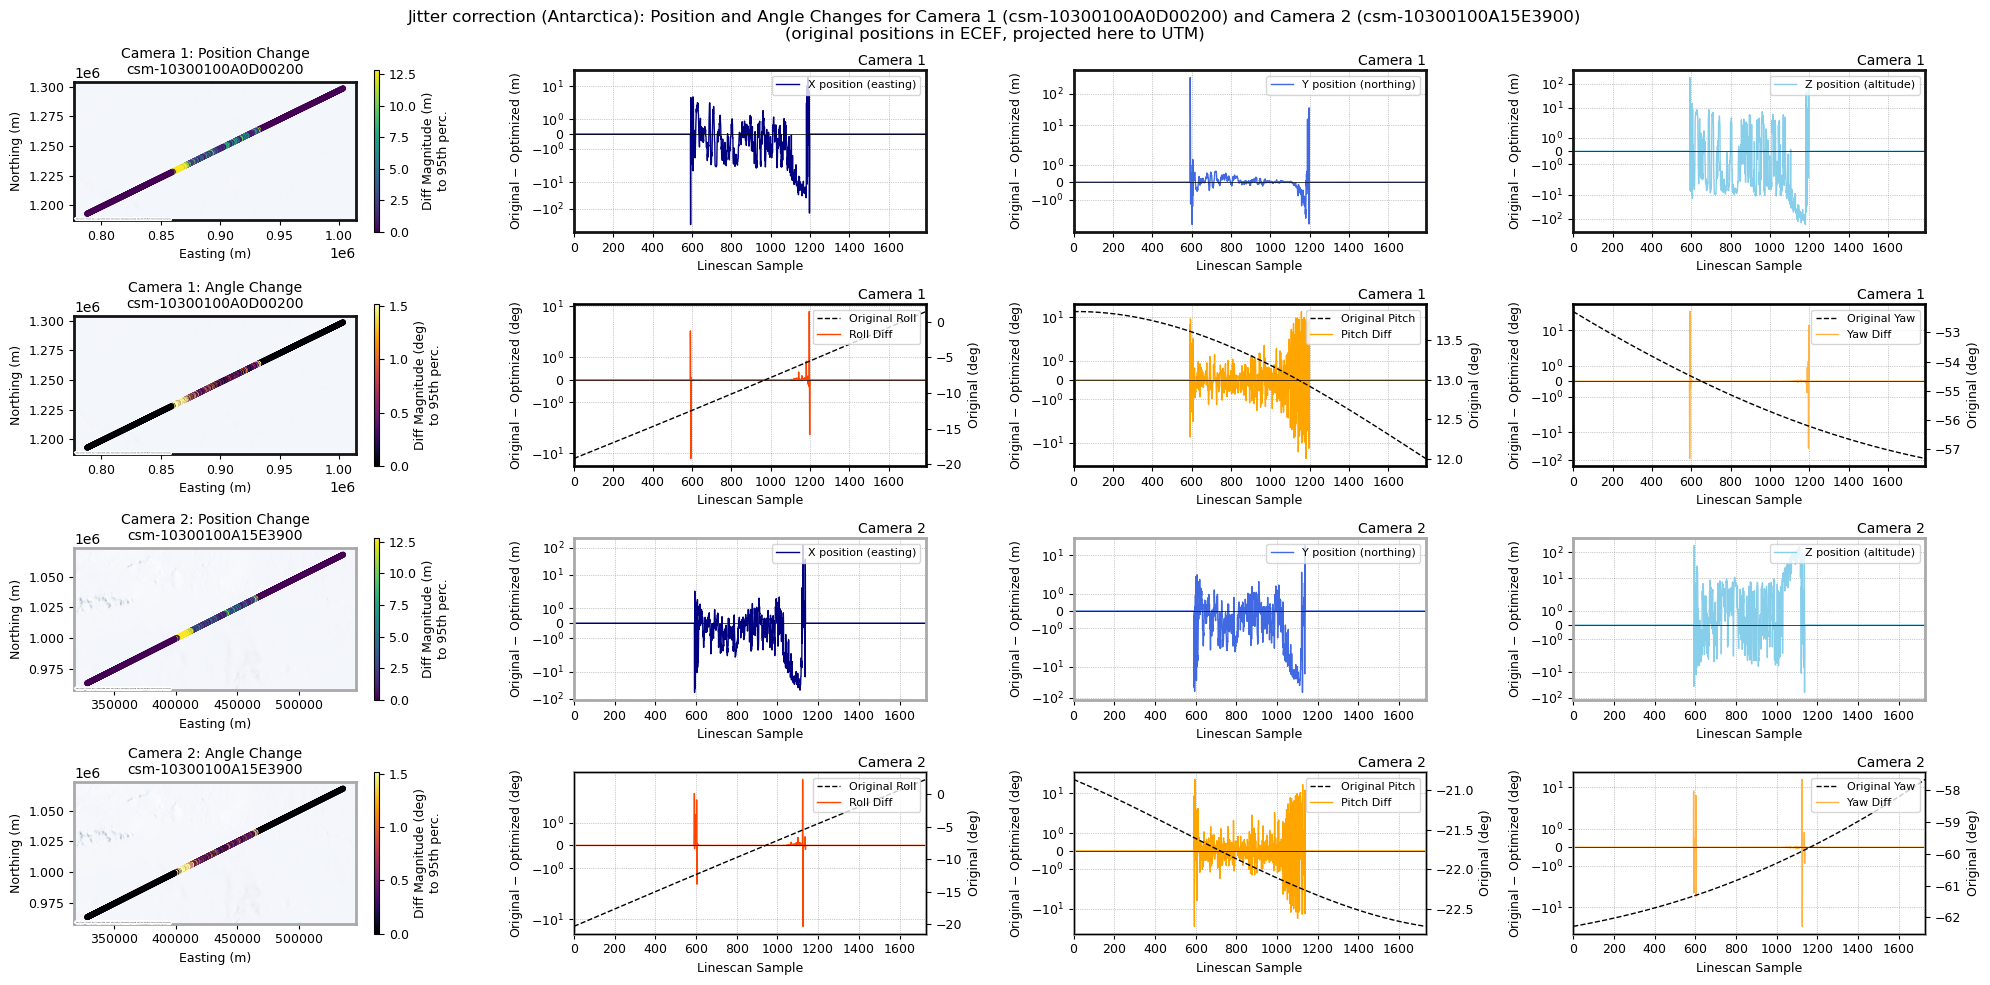

In [3]:
map_crs = "32728" # UTM 28S
title = "Jitter correction (Antarctica)"

ctx_kwargs = {
    "crs": f"EPSG:{map_crs}",
    "source": ctx.providers.Esri.WorldImagery,
    "attribution_size": 0,
    "alpha": 0.5,
}

# first set of cameras
original_camera = "../tests/test_data/jitter/antarctica_1/csm-10300100A0D00200.r100.adjusted_state.json"
optimized_camera = "../tests/test_data/jitter/antarctica_1/jitter_solved_csm-10300100A0D00200.r100.adjusted_state.json"
cam1_list = [original_camera, optimized_camera]

# second set of cameras
original_camera = "../tests/test_data/jitter/antarctica_1/csm-10300100A15E3900.r100.adjusted_state.json"
optimized_camera = "../tests/test_data/jitter/antarctica_1/jitter_solved_csm-10300100A15E3900.r100.adjusted_state.json"
cam2_list = [original_camera, optimized_camera]

summary_plot_two_camera_optimization(cam1_list, cam2_list, map_crs, title, trim=False, trim_percentage=5, near_zero_tolerance=1e-8, 
  shared_scales=False, log_scale_positions=True, log_scale_angles=True, 
  upper_magnitude_percentile=95, figsize=(20, 10), **ctx_kwargs)

## Jitter optimization for Antarctica (updated)

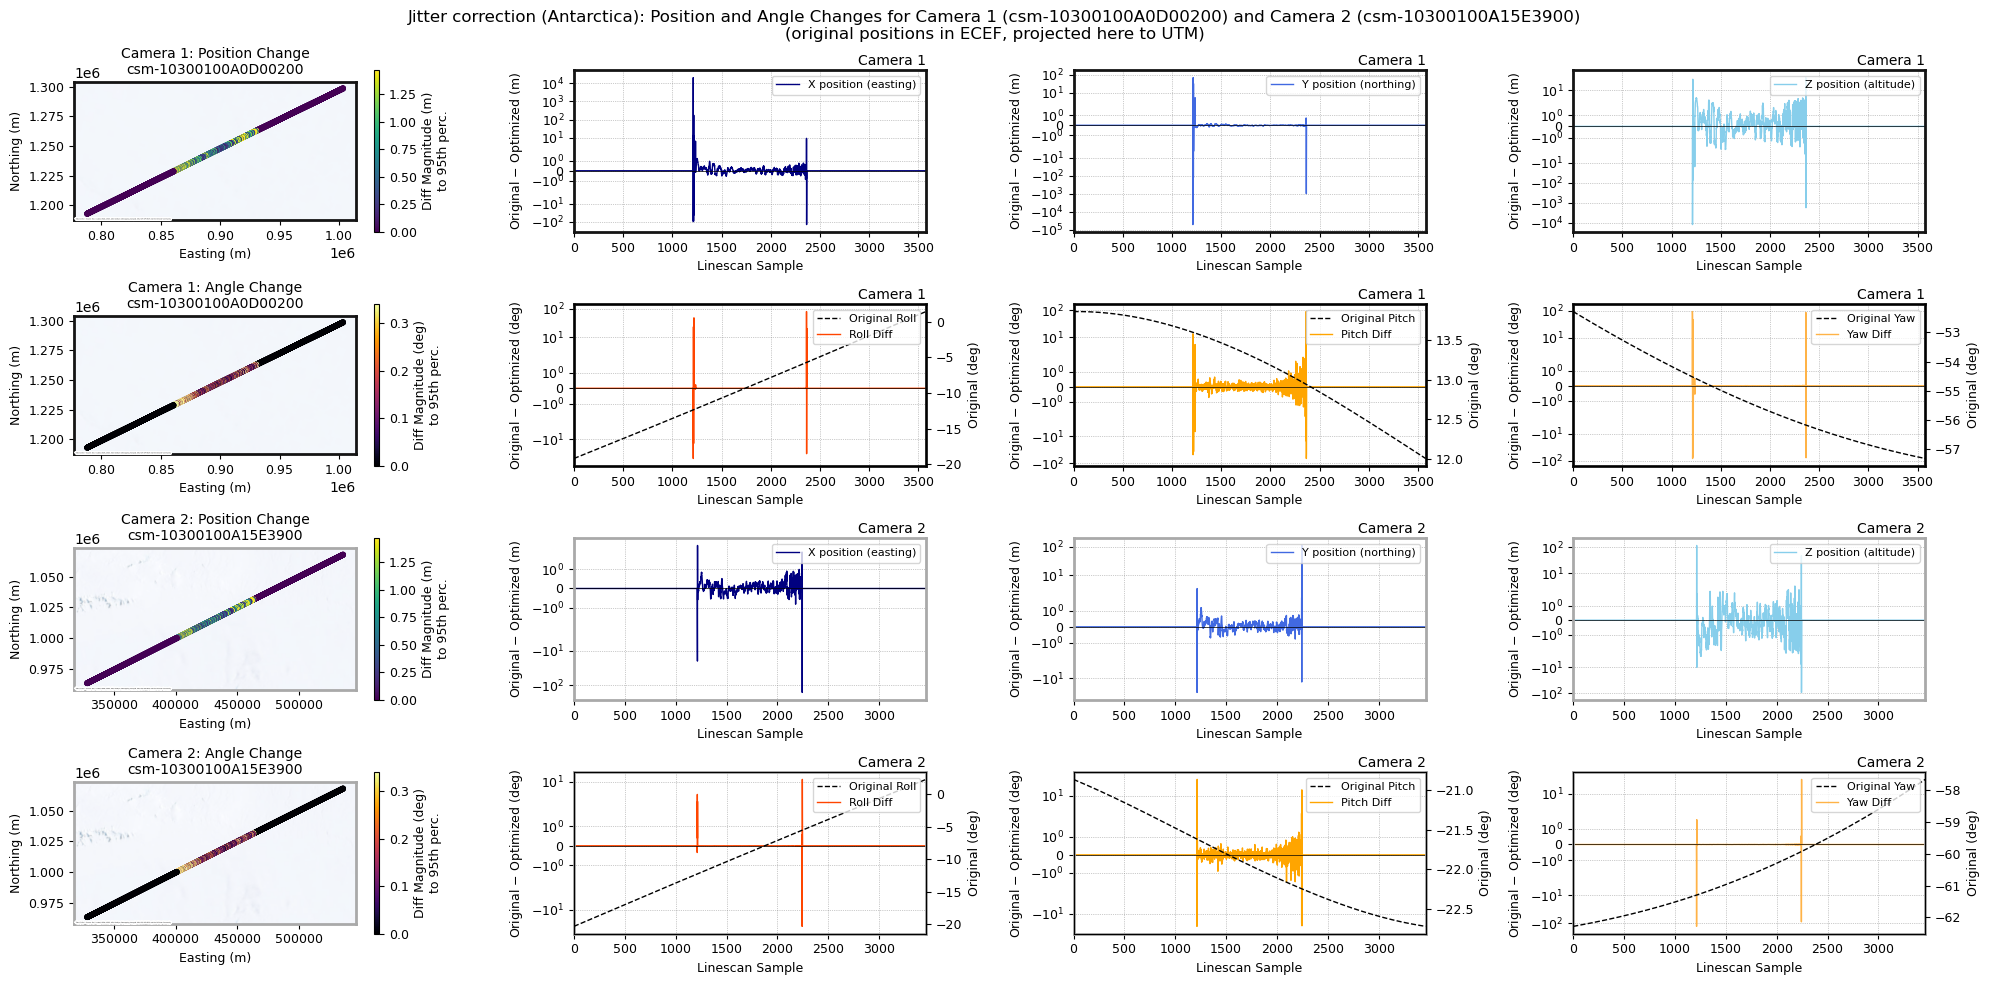

In [4]:
map_crs = "32728" # UTM 28S
title = "Jitter correction (Antarctica)"

ctx_kwargs = {
    "crs": f"EPSG:{map_crs}",
    "source": ctx.providers.Esri.WorldImagery,
    "attribution_size": 0,
    "alpha": 0.5,
}

# first set of cameras
original_camera = "../tests/test_data/jitter/antarctica_2/csm-10300100A0D00200.r100.adjusted_state.json"
optimized_camera = "../tests/test_data/jitter/antarctica_2/jitter_solved_csm-10300100A0D00200.r100.adjusted_state.json"
cam1_list = [original_camera, optimized_camera]

# second set of cameras
original_camera = "../tests/test_data/jitter/antarctica_2/csm-10300100A15E3900.r100.adjusted_state.json"
optimized_camera = "../tests/test_data/jitter/antarctica_2/jitter_solved_csm-10300100A15E3900.r100.adjusted_state.json"
cam2_list = [original_camera, optimized_camera]

summary_plot_two_camera_optimization(cam1_list, cam2_list, map_crs, title, trim=False, trim_percentage=5, near_zero_tolerance=1e-3, 
  shared_scales=False, log_scale_positions=True, log_scale_angles=True, 
  upper_magnitude_percentile=95, figsize=(20, 10), **ctx_kwargs)

## Jitter optimization Uyuni

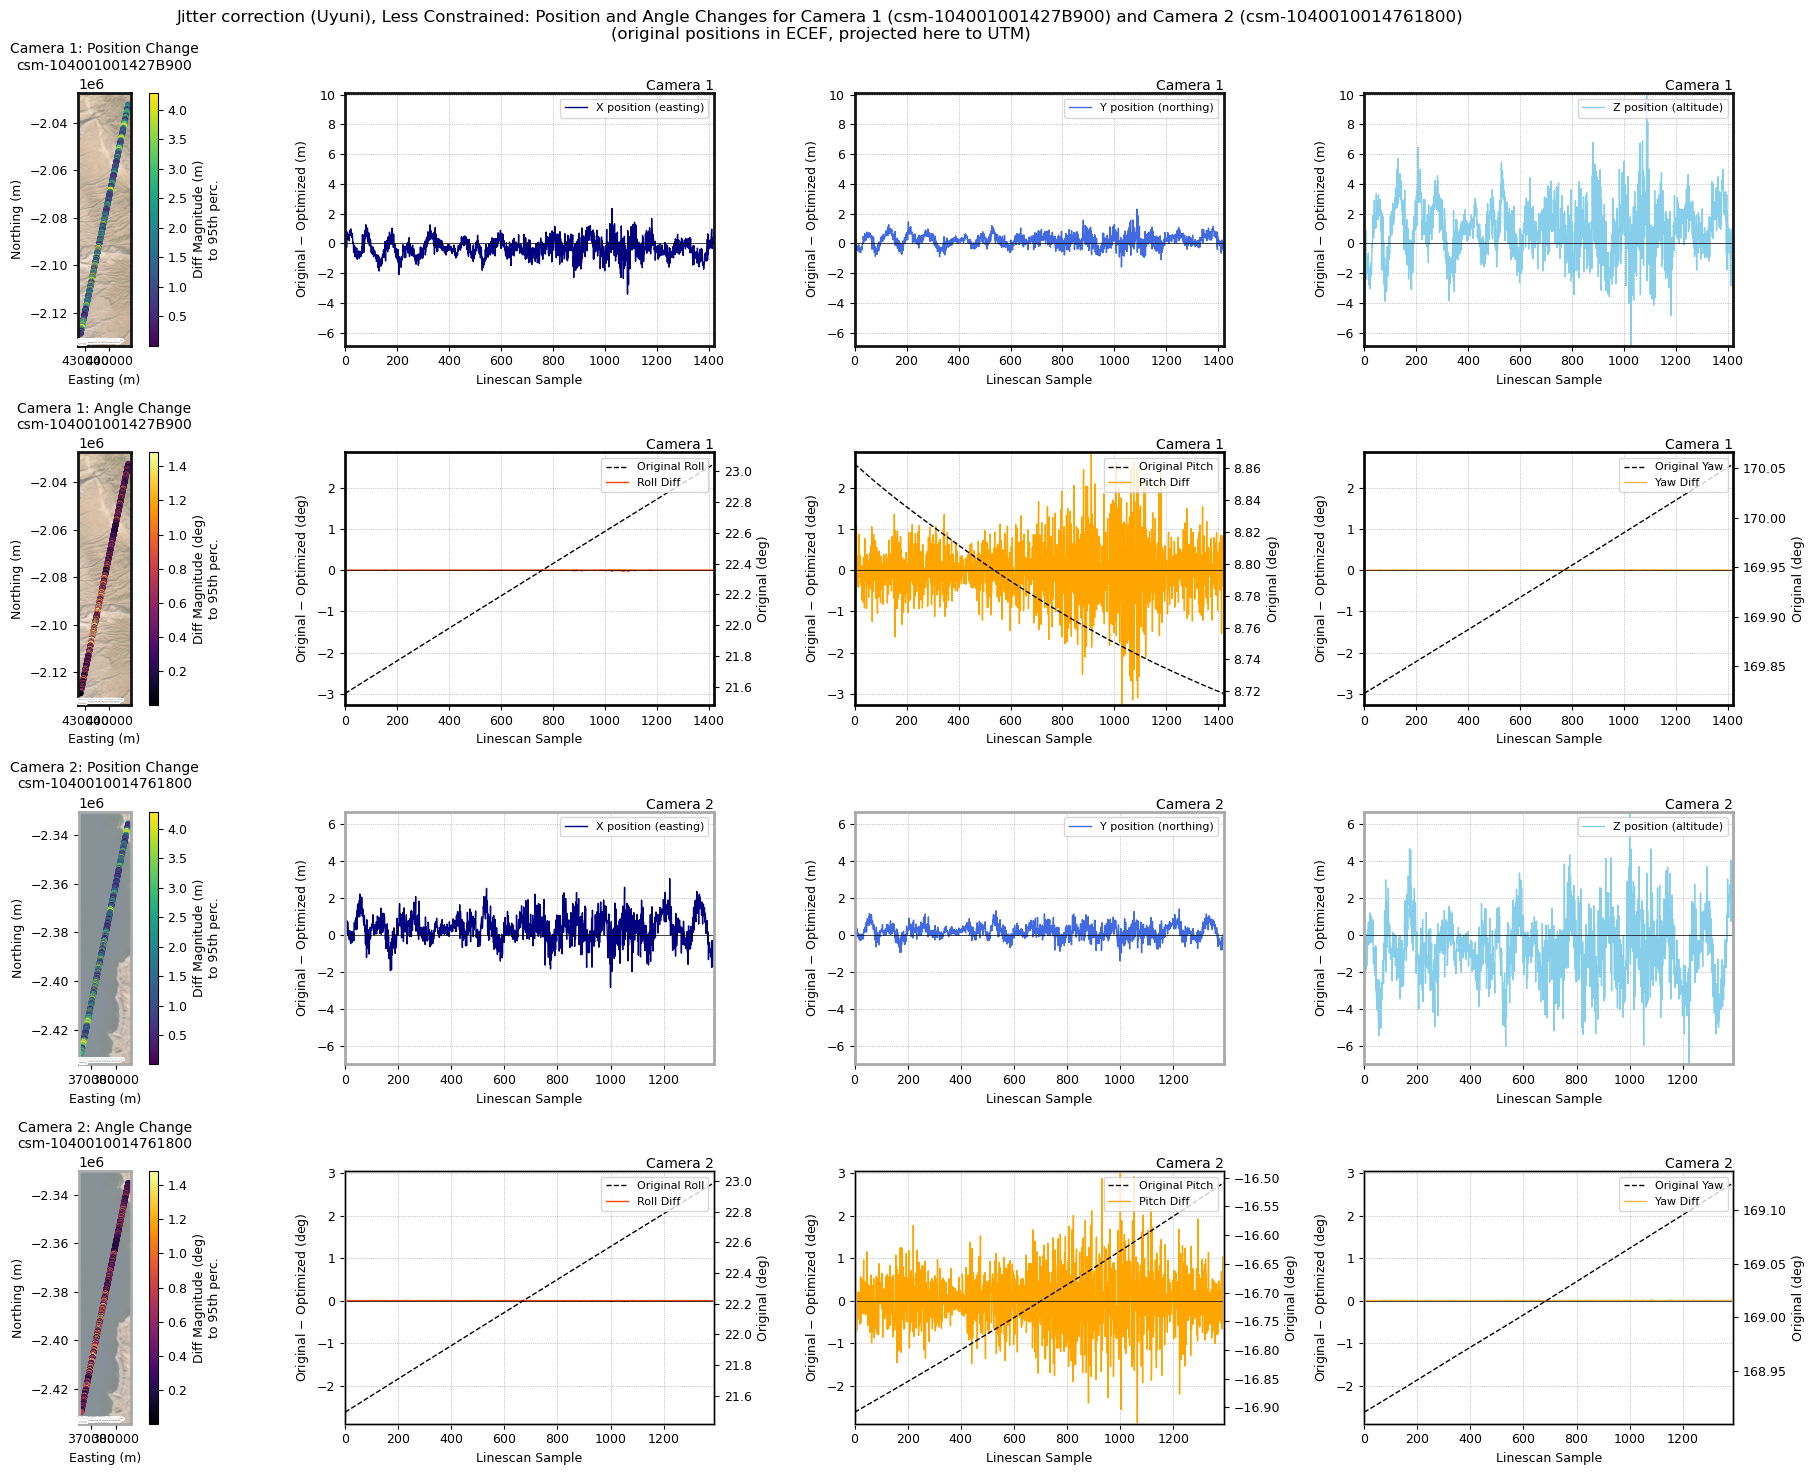

In [10]:
map_crs = "32619" # UTM 19N
title = "Jitter correction (Uyuni), Less Constrained"

ctx_kwargs = {
    "crs": f"EPSG:{map_crs}",
    "source": ctx.providers.Esri.WorldImagery,
    "attribution_size": 0,
    "alpha": 0.5,
}

# first set of cameras
original_camera = "../tests/test_data/jitter/uyuni_1/csm-104001001427B900.r100.adjusted_state.json"
optimized_camera = "../tests/test_data/jitter/uyuni_1/jitter_solved_run-csm-104001001427B900.r100.adjusted_state.json"
cam1_list = [original_camera, optimized_camera]

# second set of cameras
original_camera = "../tests/test_data/jitter/uyuni_1/csm-1040010014761800.r100.adjusted_state.json"
optimized_camera = "../tests/test_data/jitter/uyuni_1/jitter_solved_run-csm-1040010014761800.r100.adjusted_state.json"
cam2_list = [original_camera, optimized_camera]

summary_plot_two_camera_optimization(cam1_list, cam2_list, map_crs, title, trim=True, trim_percentage=10, near_zero_tolerance=1e-3, 
  shared_scales=True, log_scale_positions=False, log_scale_angles=False, 
  upper_magnitude_percentile=95, figsize=(20, 15), **ctx_kwargs)

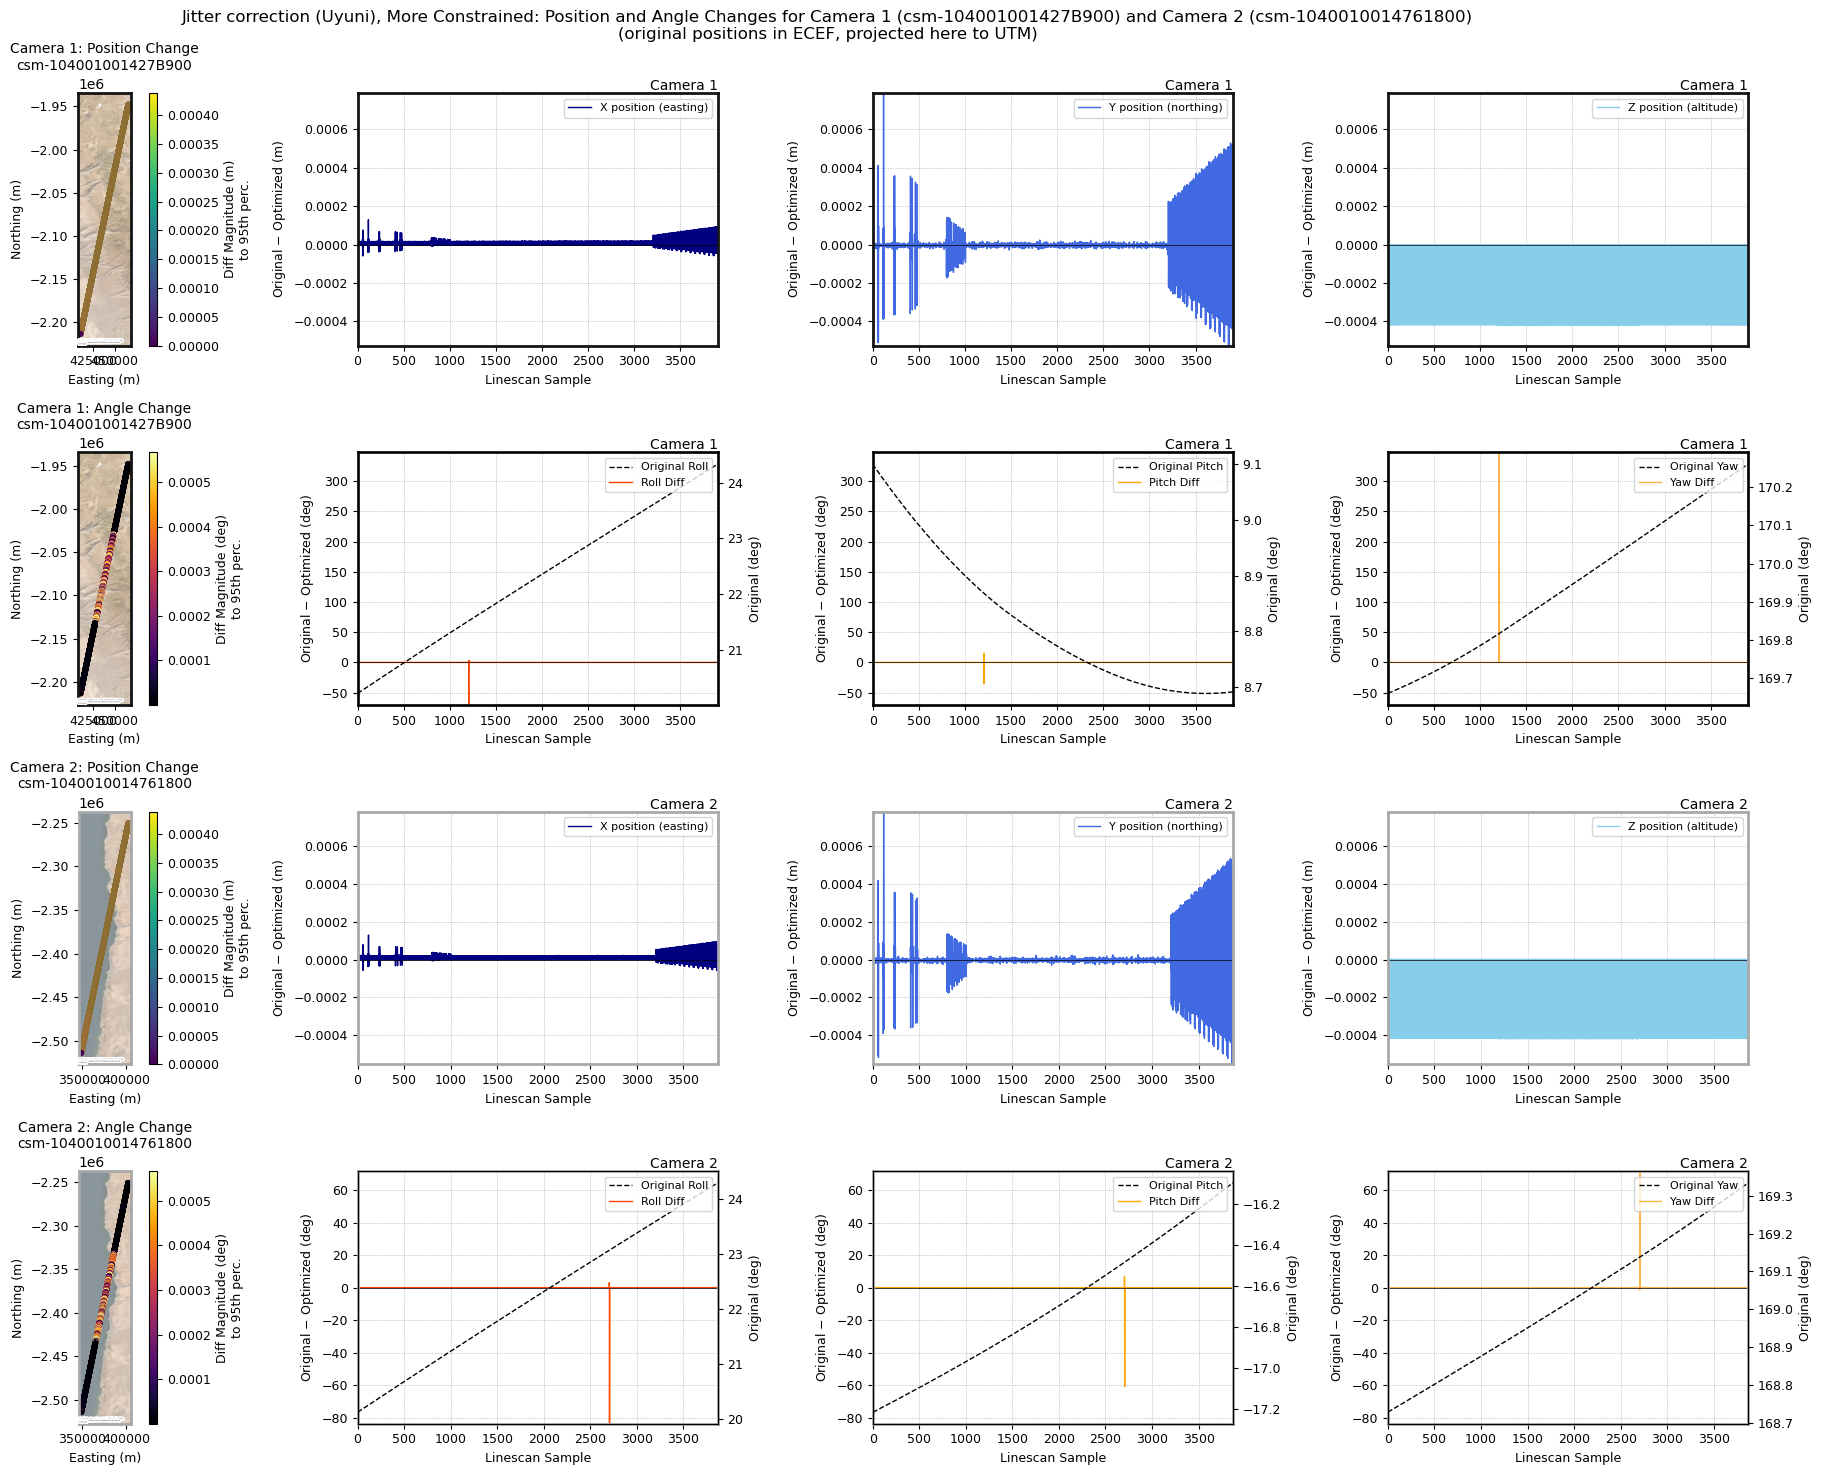

In [13]:
title = "Jitter correction (Uyuni), More Constrained"

# first set of cameras
original_camera = "../tests/test_data/jitter/uyuni_2/csm-104001001427B900.r100.adjusted_state.json"
optimized_camera = "../tests/test_data/jitter/uyuni_2/camera_pos_constraint_solution-104001001427B900.r100.adjusted_state.json"
cam1_list = [original_camera, optimized_camera]

# second set of cameras
original_camera = "../tests/test_data/jitter/uyuni_2/csm-1040010014761800.r100.adjusted_state.json"
optimized_camera = "../tests/test_data/jitter/uyuni_2/camera_pos_constraint_solution-1040010014761800.r100.adjusted_state.json"
cam2_list = [original_camera, optimized_camera]

summary_plot_two_camera_optimization(cam1_list, cam2_list, map_crs, title, trim=False, trim_percentage=65, near_zero_tolerance=1e-7, 
  shared_scales=True, log_scale_positions=False, log_scale_angles=False, 
  upper_magnitude_percentile=95, figsize=(20, 15), **ctx_kwargs)

## Bundle adjust optimization for Utqiagvik

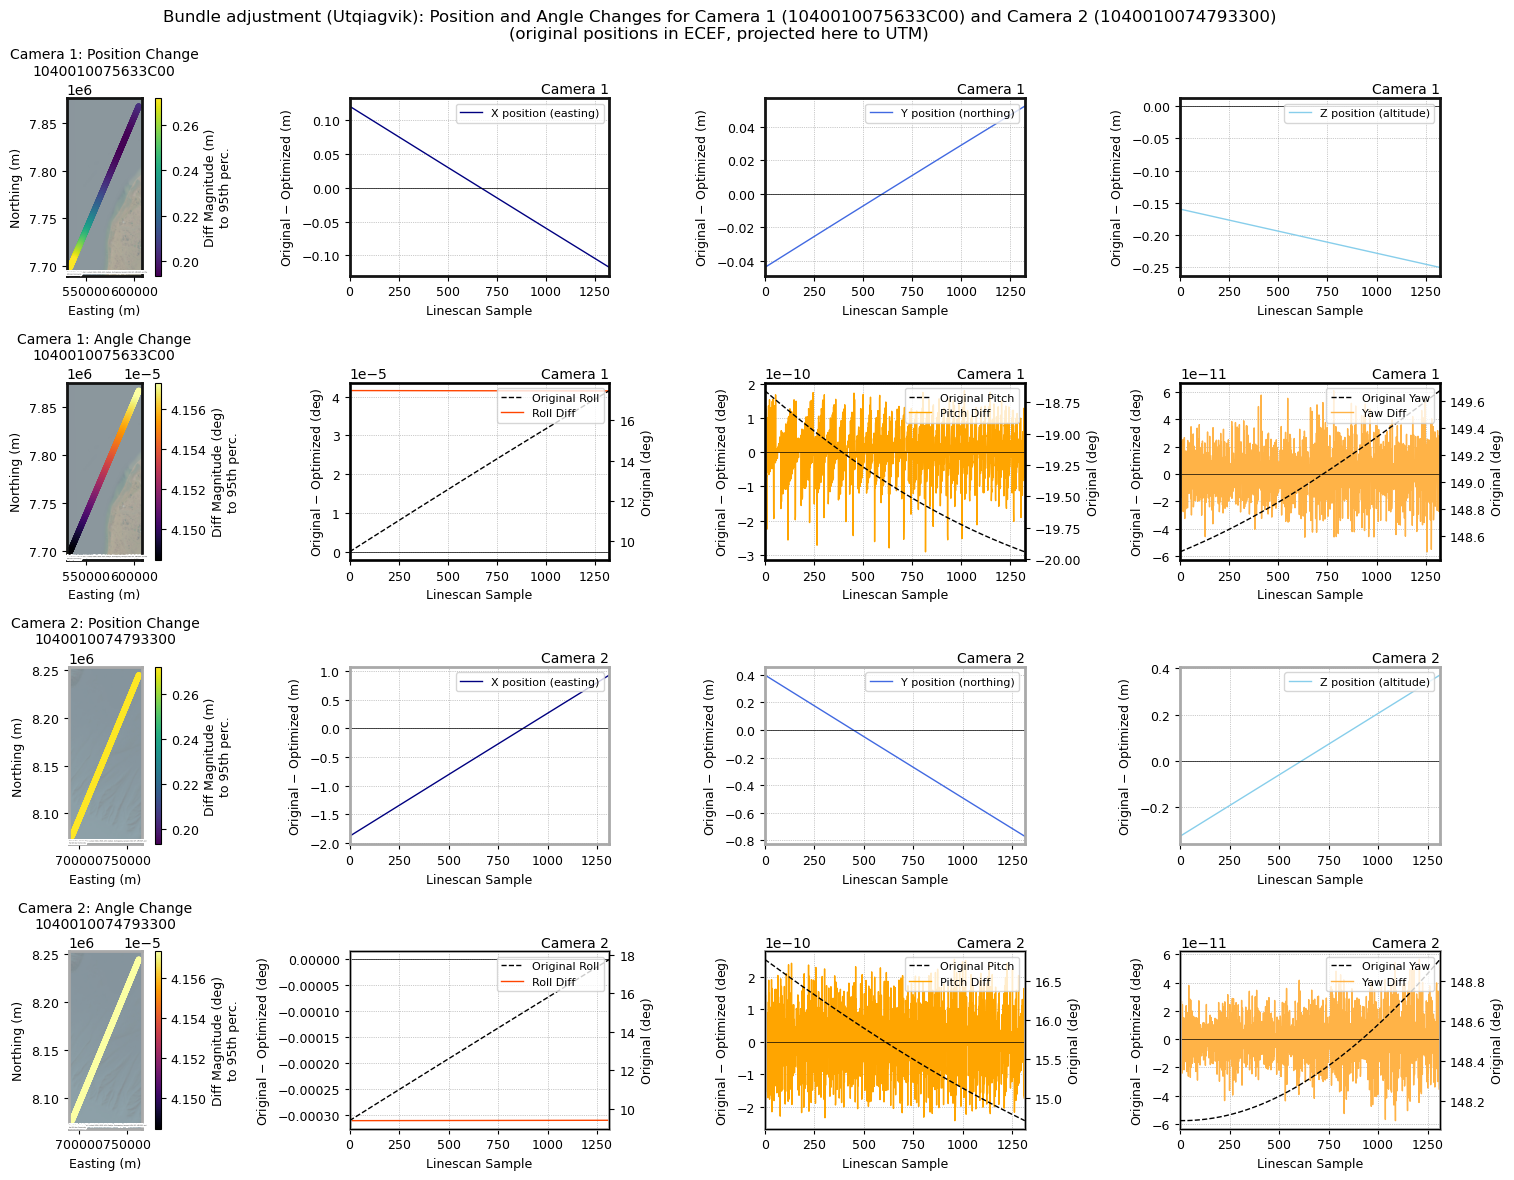

In [7]:
map_crs = "32603" # UTM 3N
title = "Bundle adjustment (Utqiagvik)"

ctx_kwargs = {
    "crs": f"EPSG:{map_crs}",
    "source": ctx.providers.Esri.WorldImagery,
    "attribution_size": 0,
    "alpha": 0.5,
}

# first set of cameras
original_camera = "../tests/test_data/ba_cams/1040010075633C00.json"
optimized_camera = "../tests/test_data/ba_cams/1040010075633C00.adjusted_state.json"
cam1_list = [original_camera, optimized_camera]

# second set of cameras
original_camera = "../tests/test_data/ba_cams/1040010074793300.json"
optimized_camera = "../tests/test_data/ba_cams/1040010074793300.adjusted_state.json"
cam2_list = [original_camera, optimized_camera]

summary_plot_two_camera_optimization(cam1_list, cam2_list, map_crs, title, trim=False, trim_percentage=10, near_zero_tolerance=1e-7,
  shared_scales=False, log_scale_positions=False, log_scale_angles=False, 
  upper_magnitude_percentile=95, figsize=(16, 12), **ctx_kwargs)